In [23]:
"""
import pandas as pd

# URL to the CSV file
url = 'https://raw.githubusercontent.com/adil200/Medical-Diagnoser/main/medical_data.csv'

# Read the CSV file from the URL into a DataFrame
df = pd.read_csv(url)

# Display the DataFrame
print(df)
"""

"\nimport pandas as pd\n\n# URL to the CSV file\nurl = 'https://raw.githubusercontent.com/adil200/Medical-Diagnoser/main/medical_data.csv'\n\n# Read the CSV file from the URL into a DataFrame\ndf = pd.read_csv(url)\n\n# Display the DataFrame\nprint(df)\n"

In [6]:
import os
import requests
import numpy as np
import pandas as pd
import numpy as np
from io import StringIO
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense


In [12]:
##  URL containing CSV data
url = 'https://raw.githubusercontent.com/adil200/Medical-Diagnoser/main/medical_data.csv'

# Make an HTTP GET request to fetch the data
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:                                                      ## 200 means reponse has been successfully created
    ## Convert the response text to a StringIO object                                   
    csv_data = StringIO(response.text)                                               ## Convert the response text to a StringIO object 

    # Load the CSV data into a DataFrame
    data = pd.read_csv(csv_data)                                                      ## data dataframe
else:
    print(f"Failed to fetch data. HTTP Status code: {response.status_code}")


In [11]:
data.head(2)

,Patient_Problem,Disease,Prescription
0,"Constant fatigue and muscle weakness, struggli...",Chronic Fatigue Syndrome,"Cognitive behavioral therapy, graded exercise ..."
1,"Frequent severe migraines, sensitivity to ligh...",Migraine with Aura,"Prescription triptans, avoid triggers like bri..."


In [13]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")                 ## Top 5000 words in vocabulary and remaining will be marked as OOV
tokenizer.fit_on_texts(data['Patient_Problem'])                                ## learns from vocabulary and will assign unique integer index to each token in the entire dataset


sequences = tokenizer.texts_to_sequences(data['Patient_Problem'])           ## used to convert a list of texts into sequences of integers based on a learned vocabulary


In [14]:
max_length = max(len(x) for x in sequences)                               ## max length among all sequences.
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')   ## padded value will be 0 by default.

In [15]:
# Encoding the labels
label_encoder_disease = LabelEncoder()
label_encoder_prescription = LabelEncoder()

disease_labels = label_encoder_disease.fit_transform(data['Disease'])                      ## We are converting categorical labels to into integers through encoding.
prescription_labels = label_encoder_prescription.fit_transform(data['Prescription'])       ## We are converting categorical labels to into integers through encoding.

# Converting labels to categorical
disease_labels_categorical = to_categorical(disease_labels)                                   ## Again converting these integres into categorical format(one-hot-encoding
prescription_labels_categorical = to_categorical(prescription_labels)                       ## Again converting these integres into categorical format(one-hot-encoding)


In [16]:
Y = np.hstack((disease_labels_categorical, prescription_labels_categorical))                  ## It will horizontally stack 2 arrays that are dependent variables into one dependent variable


In [17]:
input_layer = Input(shape=(max_length,)) # Input layer of neauron

embedding = Embedding(input_dim=5000, output_dim=64)(input_layer)
lstm_layer = LSTM(64)(embedding)

disease_output = Dense(len(label_encoder_disease.classes_), activation='softmax',
name='disease_output')(lstm_layer)

prescription_output = Dense(len(label_encoder_prescription.classes_),
activation='softmax', name='prescription_output')(lstm_layer)


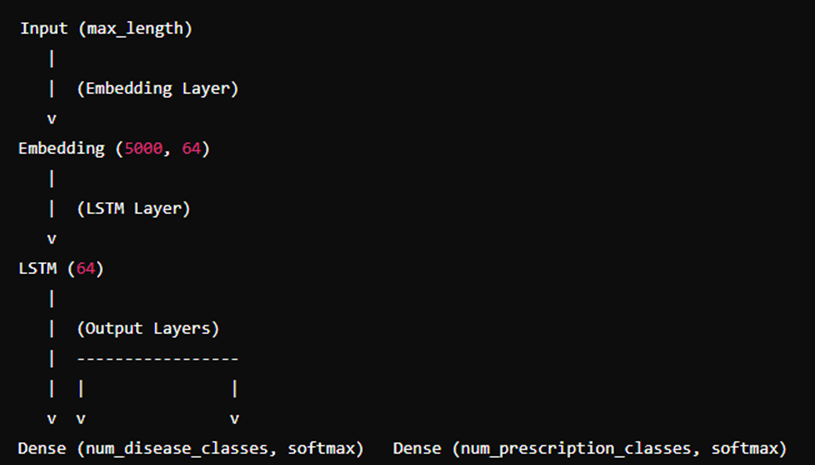

In [19]:
model = Model(inputs=input_layer, outputs=[disease_output, prescription_output])           ## 2 outputs disease and prescription

model.compile(
    loss={'disease_output': 'categorical_crossentropy',
    'prescription_output': 'categorical_crossentropy'},
    optimizer='adam',
    metrics={'disease_output': ['accuracy'], 'prescription_output': ['accuracy']}
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 17)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 17, 64)               320000    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 64)                   33024     ['embedding[0][0]']           
                                                                                                  
 disease_output (Dense)      (None, 178)                  11570     ['lstm[0][0]']                
                                                                                              

In [20]:
model.fit(padded_sequences, {'disease_output': disease_labels_categorical, 'prescription_output':                   ## Btach size-subset of traing dataset
      prescription_labels_categorical}, epochs=100, batch_size=32)                                             ## 1 epoch means learns from entire dataset and adjusts weights in back propogation

Epoch 1/100
13/13 [==============================] - 4s 33ms/step - loss: 11.1460 - disease_output_loss: 5.1804 - prescription_output_loss: 5.9655 - disease_output_accuracy: 0.0246 - prescription_output_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 36ms/step - loss: 11.1284 - disease_output_loss: 5.1666 - prescription_output_loss: 5.9618 - disease_output_accuracy: 0.0344 - prescription_output_accuracy: 0.0074
Epoch 3/100
13/13 [==============================] - 1s 50ms/step - loss: 11.0986 - disease_output_loss: 5.1358 - prescription_output_loss: 5.9629 - disease_output_accuracy: 0.0319 - prescription_output_accuracy: 0.0049
Epoch 4/100
13/13 [==============================] - 0s 32ms/step - loss: 11.0051 - disease_output_loss: 5.0145 - prescription_output_loss: 5.9905 - disease_output_accuracy: 0.0319 - prescription_output_accuracy: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 0s 33ms/step - loss: 10.8331 - disease_output_loss: 4.8886 

In [21]:
def make_prediction(patient_problem):
    # Preprocessing the input
    sequence = tokenizer.texts_to_sequences([patient_problem])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Making prediction
    prediction = model.predict(padded_sequence)

    # Decoding the prediction
    disease_index = np.argmax(prediction[0], axis=1)[0]
    prescription_index = np.argmax(prediction[1], axis=1)[0]

    disease_predicted = label_encoder_disease.inverse_transform([disease_index])[0]
    prescription_predicted = label_encoder_prescription.inverse_transform([prescription_index])[0]

    print(f"Predicted Disease: {disease_predicted}")
    print(f"Suggested Prescription: {prescription_predicted}")


patient_input = "I've experienced a loss of appetite and don't enjoy food anymore."
make_prediction(patient_input)


1/1 [==============================] - 1s 520ms/step
Predicted Disease: Tinnitus
Suggested Prescription: Antidepressants; eating nutrient-rich foods.
